Import dependencies

In [2]:
from huggingface_hub import login as huggingface_hub_login
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModelForCausalLM
import torch
import pandas as pd
import re
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os


Login to hugging face

In [3]:
hugging_face_token = "***REMOVED***"

huggingface_hub_login(hugging_face_token)


Configure 4-bit quantization for balancing accuracy and speed

In [4]:
# Configure 4-bit quantization
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

Load CodeLlama from Hugging Face

In [5]:
model_name = "meta-llama/CodeLlama-7b-hf"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# If the tokenizer has no padding token, add one to supress warnings
if tokenizer.pad_token is None:
      tokenizer.pad_token = tokenizer.eos_token

# Load model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map="auto"
)

# Check device mapping
print(model.hf_device_map)

c:\Users\alals\repos\perf-pilot\venv\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\alals\.cache\huggingface\hub\models--meta-llama--CodeLlama-7b-hf. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplic

RuntimeError: CUDA is required but not available for bitsandbytes. Please consider installing the multi-platform enabled version of bitsandbytes, which is currently a work in progress. Please check currently supported platforms and installation instructions at https://huggingface.co/docs/bitsandbytes/main/en/installation#multi-backend

Model evaluation function

In [ ]:
def assess_bug_risk(pr_description, code_diff):
    # Create a detailed prompt
    prompt = f"""
    Analyze the following pull request and predict the risk of introducing a bug.

    Pull Request Description:
    {pr_description}

    Code Changes:
    {code_diff}

    Provide only the risk percentage (0% to 100%).

    Risk Percentage:
    """

    # Tokenize the prompt
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")

    # Generate model output
    outputs = model.generate(**inputs, max_new_tokens=10, temperature=0.1, pad_token_id=tokenizer.pad_token_id)

    # Decode the output
    result = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return result


Example usage

In [ ]:
# Example Pull Request description and code changes
pr_description = "Refactored the payment processing function to improve performance."
code_diff = """
- def process_payment(order):
-     validate_card(order.card)
-     charge_card(order.amount)
-     send_receipt(order)

+ def process_payment(order):
+     if not order.is_valid():
+         raise ValueError("Invalid order")
+     charge_card(order.amount)
"""

# Get bug risk assessment
prediction = assess_bug_risk(pr_description, code_diff)
print("Model Prediction:", prediction)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Model Prediction: 
    Analyze the following pull request and predict the risk of introducing a bug.

    Pull Request Description:
    Refactored the payment processing function to improve performance.

    Code Changes:
    
- def process_payment(order):
-     validate_card(order.card)
-     charge_card(order.amount)
-     send_receipt(order)

+ def process_payment(order):
+     if not order.is_valid():
+         raise ValueError("Invalid order")
+     charge_card(order.amount)


    Provide only the risk percentage (0% to 100%).

    Risk Percentage:
    
- 100%

+


Import test dataset

In [ ]:
# Load the CSV into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/risk_data/risk.csv')
df.head()

,pr_description,code_diff,label
0,Fix user login issue,- if user.is_active:\n+ if user.is_authenticat...,0
1,Refactor payment function,- charge_card(order.amount)\n+ if order.is_val...,1
2,Update README documentation,+ Added installation instructions,0
3,Optimize search function,"- return results\n+ return sorted(results, key...",0
4,Remove null checks (testing purpose),- if value is not None:\n- process(value)\...,1


Run the model and extract prediction

In [ ]:
def extract_percentage(text):
    match = re.search(r'(\d{1,3})%', text)
    if match:
        return int(match.group(1))
    return 0  # If no percentage is found, assume 0%

# Predict bug risk for each PR in the dataset
df['predicted_risk'] = df.apply(lambda row: assess_bug_risk(row['pr_description'], row['code_diff']), axis=1)

# Convert model output to numeric percentage
df['predicted_risk_percentage'] = df['predicted_risk'].apply(extract_percentage)

# Convert percentage to binary prediction (risk > 50% = bug)
df['predicted_label'] = df['predicted_risk_percentage'].apply(lambda x: 1 if x > 50 else 0)


/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Evaluate performance

In [ ]:
print("Classification Report:\n", classification_report(df['label'], df['predicted_label']))
print("Accuracy:", accuracy_score(df['label'], df['predicted_label']))


Classification Report:
               precision    recall  f1-score   support

           0       0.60      1.00      0.75         3
           1       0.00      0.00      0.00         2

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5

Accuracy: 0.6


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Visualize the results

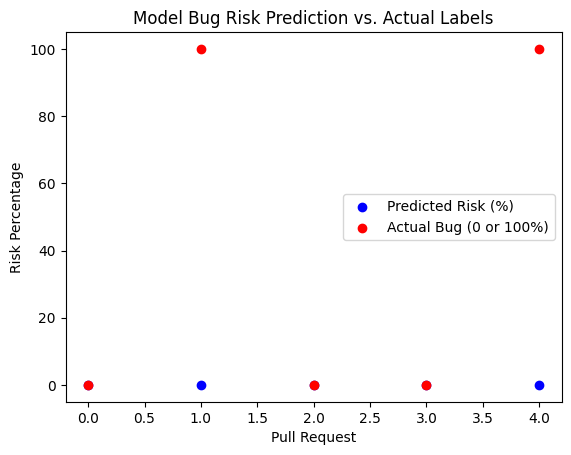

In [ ]:
plt.scatter(df.index, df['predicted_risk_percentage'], color='blue', label='Predicted Risk (%)')
plt.scatter(df.index, df['label'] * 100, color='red', label='Actual Bug (0 or 100%)')
plt.xlabel('Pull Request')
plt.ylabel('Risk Percentage')
plt.title('Model Bug Risk Prediction vs. Actual Labels')
plt.legend()
plt.show()
